# HuggingFace로 영화리뷰 감정 분석 모델 구현하기

이번 실습에서는 HuggingFace로 영화리뷰 감정 분석과 같은 text 분류 문제를 위한 모델을 구현합니다.
먼저 필요한 library들을 설치하고 import합니다.


In [1]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Dataset 준비

그 다음 감정 분석을 위해 사용할 imdb dataset을 `load_dataset` 함수로 다운로드 받습니다.


In [2]:
imdb = load_dataset("imdb")
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

`load_dataset`은 HuggingFace의 `datasets` library의 함수로, HuggingFace의 hub에서 dataset을 다운로드 받을 수 있도록 만든 함수입니다.
출력 결과를 보시면 `imdb`는 `train`, `test`, 그리고 `unsupervised` data로 구성되어있습니다.
이 중에서 우리는 `train`과 `test`를 활용합니다.

`train` data를 한 번 살펴보겠습니다.


In [3]:
imdb["train"][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

`train`과 `test`의 각 data는 `text`와 `label`로 구성되어있습니다.
각각은 영화리뷰와 해당 영화리뷰의 긍정/부정 여부를 의미합니다.
이는 이전 주차들에서 사용한 imdb dataset과 동일합니다.

이번에는 tokenizer를 불러와서 미리 text들을 tokenize합니다.


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)


imdb_tokenized = imdb.map(preprocess_function, batched=True)

Tokenizer를 실행할 때 넘겨주었던 `truncation` 옵션은 주어진 text가 일정 길이 이상이면 잘라내라는 의미입니다.
만약 특정 길이 값이 같이 주어지지 않는다면 `bert-base-cased`를 학습할 때 사용한 text의 최대 길이를 기준으로 값을 결정합니다.


In [5]:
imdb_tokenized["train"][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

마지막 출력 결과를 보면, `text`와 `label` 이외에 `input_ids`가 생기신 것을 확인하실 수 있습니다.
이는 우리가 `AutoTokenizer.from_pretrained`로 불러온 tokenizer로 text를 token들로 나누고 정수 index로 변환한 결과입니다.

이번에는 `train` data를 쪼개 training data와 validation data를 만들어보겠습니다.


In [6]:
imdb_split = imdb_tokenized["train"].train_test_split(test_size=0.2)
imdb_train, imdb_val = imdb_split["train"], imdb_split["test"]
imdb_test = imdb_tokenized["test"]

HuggingFace `datasets`로 불러온 dataset은 `train_test_split`으로 쉽게 쪼갤 수 있습니다.

다음은 각 split의 크기입니다.


In [7]:
len(imdb_train), len(imdb_val), len(imdb_test)

(20000, 5000, 25000)

## Model 구현

이번에는 text 분류를 수행할 Transformer를 구현합니다.
이전에는 Transformer의 구성 요소들을 직접 구현하여 합쳤습니다.
이번에는 HuggingFace의 BERT를 활용하여 인자만 넘겨주는 식으로 구현해보겠습니다:


In [71]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = 2  # 마지막에 예측해야 하는 분류 문제의 class 개수

model = AutoModelForSequenceClassification.from_config(config)

BERT는 이전에 배운 Transformer의 architecture를 그대로 사용합니다.
그래서 BERT의 옵션들만 수정하면 vanilla Transformer를 쉽게 구현할 수 있습니다.

Transformer 구현 이외에 분류 문제에 맞춰 첫 번째 token을 linear classifier를 거치는 등의 과정은 `AutoModelForSequenceClassification`이 구현해줍니다.
즉, 우리가 `config`로 넘겨주는 BERT의 마지막에 linear classifier를 달아주는 역할을 합니다.


## 학습 코드

다음은 위에서 구현한 Transformer를 imdb로 학습하는 코드를 구현합니다.
먼저 다음과 같이 학습 인자들을 정의합니다.


In [72]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="hf_transformer",  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="eval_accuracy",  # best model을 accuracy 기준으로 선정
    greater_is_better=True,
)

각각의 부분들은 이전 주차에서 배웠던 내용들을 설정하는 것에 불과하다는 것을 알 수 있습니다.
요약하면 다음과 같습니다:

- `epochs`: training data를 몇 번 반복할 것인지 결정합니다.
- `batch_size`: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- `learning_rate`: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.
  위의 부분들 이외에도 사소한 구현 요소들도 지정할 수 있습니다.

다음은 loss 이외의 평가 함수들을 구현하는 방법입니다.


In [65]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.


In [78]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt


class PlotCallback(TrainerCallback):
    def __init__(self):
        self.epochs = []
        self.train_loss = []
        self.eval_loss = []
        self.eval_accuracy = []
        self.during_training = True

    def on_log(self, args, state, control, logs=None, **kwargs):
        # train_loss를 로그에서 가져와 저장
        if "loss" in logs:
            self.train_loss.append(logs["loss"])

    def on_train_begin(self, args, state, control, **kwargs):
        # 학습이 시작될 때 상태를 학습 중으로 설정
        self.during_training = True

    def on_train_end(self, args, state, control, **kwargs):
        # 학습이 끝났을 때 플래그를 학습 중이 아닌 상태로 설정
        self.during_training = False

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # 평가만 수행될 때는 그래프를 그리지 않음
        if not self.during_training:
            return  # 평가 중일 때는 플롯을 그리지 않음

        # state.epoch가 None이 아닌 경우에만 추가
        if state.epoch is not None and state.epoch not in self.epochs:
            self.epochs.append(state.epoch)

        if metrics:
            if "eval_loss" in metrics:
                self.eval_loss.append(metrics["eval_loss"])
            if "eval_accuracy" in metrics:
                self.eval_accuracy.append(metrics["eval_accuracy"])

        # 매 validation이 끝날 때만 그래프를 그림
        self.plot(args.num_train_epochs)

    def plot(self, total_epochs):
        plt.figure(figsize=(10, 6))

        # Train Loss Plot (Epoch에 따라 찍힌 train_loss 값들)
        if len(self.train_loss) > 0:
            plt.subplot(3, 1, 1)
            plt.plot(
                self.epochs[: len(self.train_loss)],
                self.train_loss,
                marker="o",
                label="Train Loss",
                color="blue",
            )
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Train Loss per Epoch")
            plt.grid(True)
            plt.xlim(0, total_epochs + 1)  # x축 범위 설정
            plt.xticks(
                range(0, total_epochs + 1)
            )  # x축을 0부터 total_epochs까지 정수로만 설정

        # Eval Loss Plot
        if len(self.eval_loss) > 0:
            plt.subplot(3, 1, 2)
            plt.plot(
                self.epochs[: len(self.eval_loss)],
                self.eval_loss,
                marker="o",
                label="Eval Loss",
                color="red",
            )
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Eval Loss per Epoch")
            plt.grid(True)
            plt.xlim(0, total_epochs + 1)  # x축 범위 설정
            plt.xticks(
                range(0, total_epochs + 1)
            )  # x축을 0부터 total_epochs까지 정수로만 설정

        # Eval Accuracy Plot
        if len(self.eval_accuracy) > 0:
            plt.subplot(3, 1, 3)
            plt.plot(
                self.epochs[: len(self.eval_accuracy)],
                self.eval_accuracy,
                marker="o",
                label="Eval Accuracy",
                color="green",
            )
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title("Eval Accuracy per Epoch")
            plt.grid(True)
            plt.xlim(0, total_epochs + 1)  # x축 범위 설정
            plt.xticks(
                range(0, total_epochs + 1)
            )  # x축을 0부터 total_epochs까지 정수로만 설정

        plt.tight_layout()
        plt.show()

In [80]:
class BestModelCallback(TrainerCallback):
    def __init__(self):
        self.best_checkpoint = None
        self.best_metric = None
        self.step_to_epoch_map = {}  # step을 epoch로 매핑하는 딕셔너리

    def on_step_end(self, args, state, control, **kwargs):
        # 매 스텝마다 step -> epoch 매핑 생성
        global_step = state.global_step
        current_epoch = state.epoch

        # 매핑을 딕셔너리에 저장
        self.step_to_epoch_map[global_step] = current_epoch

    def on_train_end(self, args, state, control, **kwargs):
        # 가장 좋은 모델의 체크포인트와 메트릭 정보를 가져옴
        self.best_checkpoint = state.best_model_checkpoint
        self.best_metric = state.best_metric

        # 메트릭 종류 확인 (eval_loss를 기본으로 사용)
        metric_name = (
            args.metric_for_best_model if args.metric_for_best_model else "eval_loss"
        )

        if self.best_checkpoint:
            global_step = int(self.best_checkpoint.split("-")[-1])

            # step -> epoch 매핑에서 해당 step의 epoch 가져오기
            best_epoch = self.step_to_epoch_map.get(global_step, "Unknown epoch")

            print(f"Best model was saved at: {self.best_checkpoint}")
            print(f"Best epoch: {best_epoch}")
            print(f"Best {metric_name}: {self.best_metric}")
        else:
            print("No best model found.")

In [81]:
from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        PlotCallback(),
        BestModelCallback(),
    ],
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
)

모델, training 인자, training과 validation data, 부가적인 평가 함수, 그리고 tokenizer를 넘겨주면 끝입니다.
별개로 early stopping과 같은 기능도 주석 친 부분과 같이 `callbacks`로 구현할 수 있으니 참고해주시길 바랍니다.

위와 같이 만든 `Trainer`는 다음과 같이 학습을 할 수 있습니다.


  0%|          | 0/1570 [00:00<?, ?it/s]

{'loss': 0.2023, 'grad_norm': 2.5090715885162354, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.30362269282341003, 'eval_accuracy': 0.8824, 'eval_runtime': 3.4983, 'eval_samples_per_second': 1429.252, 'eval_steps_per_second': 11.434, 'epoch': 1.0}


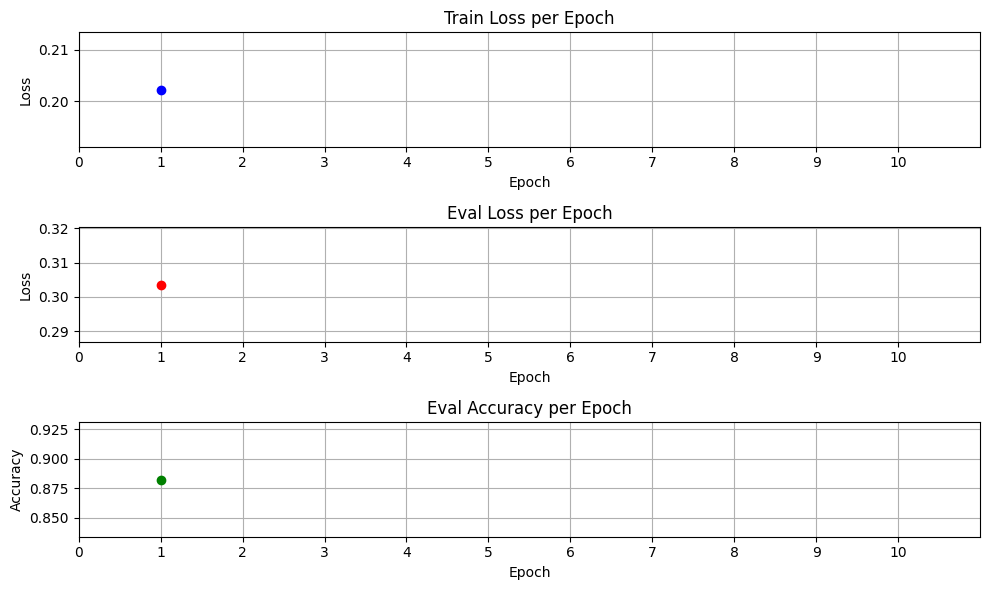

{'loss': 0.1119, 'grad_norm': 9.238507270812988, 'learning_rate': 0.0008, 'epoch': 2.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.34709906578063965, 'eval_accuracy': 0.876, 'eval_runtime': 3.4313, 'eval_samples_per_second': 1457.172, 'eval_steps_per_second': 11.657, 'epoch': 2.0}


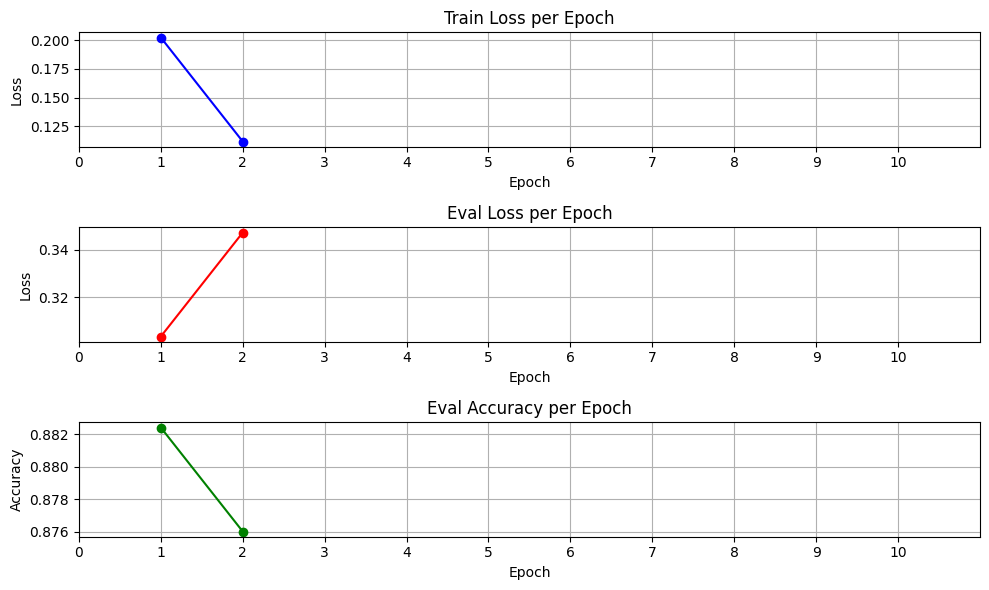

{'loss': 0.0527, 'grad_norm': 0.9758796095848083, 'learning_rate': 0.0007, 'epoch': 3.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.4772825241088867, 'eval_accuracy': 0.8706, 'eval_runtime': 3.4146, 'eval_samples_per_second': 1464.295, 'eval_steps_per_second': 11.714, 'epoch': 3.0}


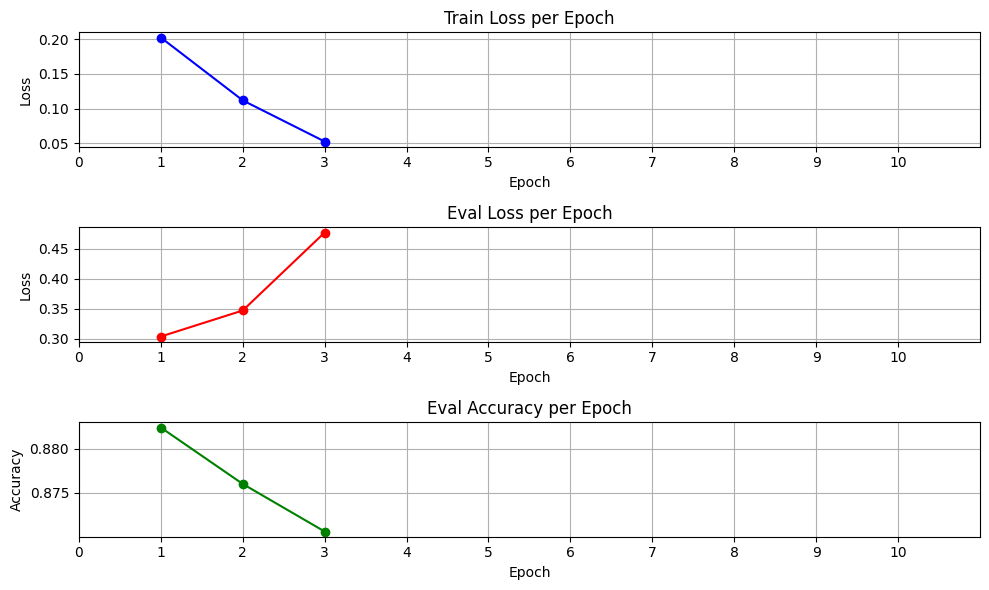

{'loss': 0.0306, 'grad_norm': 0.3462805449962616, 'learning_rate': 0.0006, 'epoch': 4.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.6072447299957275, 'eval_accuracy': 0.869, 'eval_runtime': 3.5481, 'eval_samples_per_second': 1409.199, 'eval_steps_per_second': 11.274, 'epoch': 4.0}


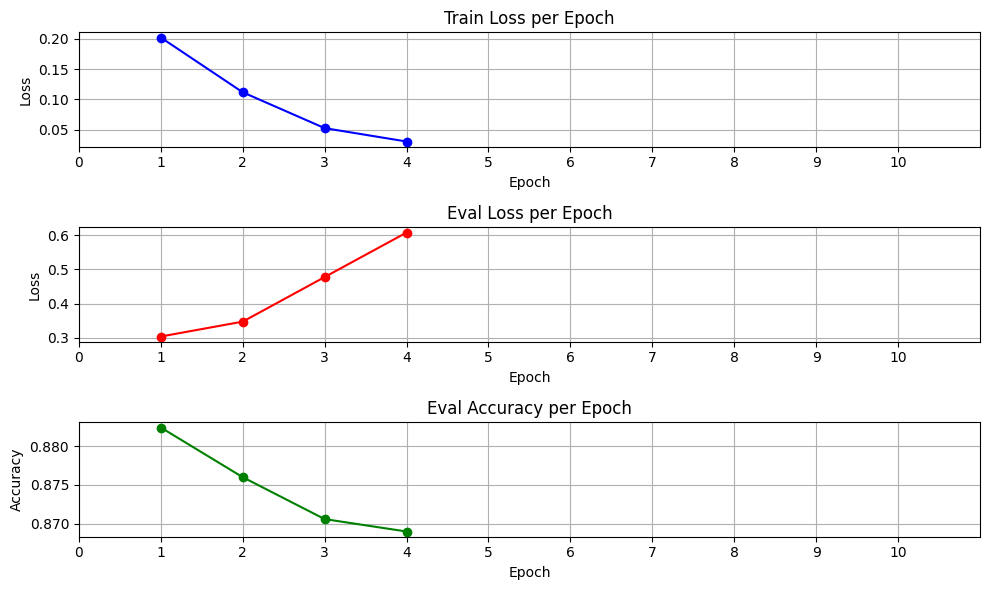

{'loss': 0.0173, 'grad_norm': 4.704046726226807, 'learning_rate': 0.0005, 'epoch': 5.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.6695528030395508, 'eval_accuracy': 0.8678, 'eval_runtime': 3.4885, 'eval_samples_per_second': 1433.291, 'eval_steps_per_second': 11.466, 'epoch': 5.0}


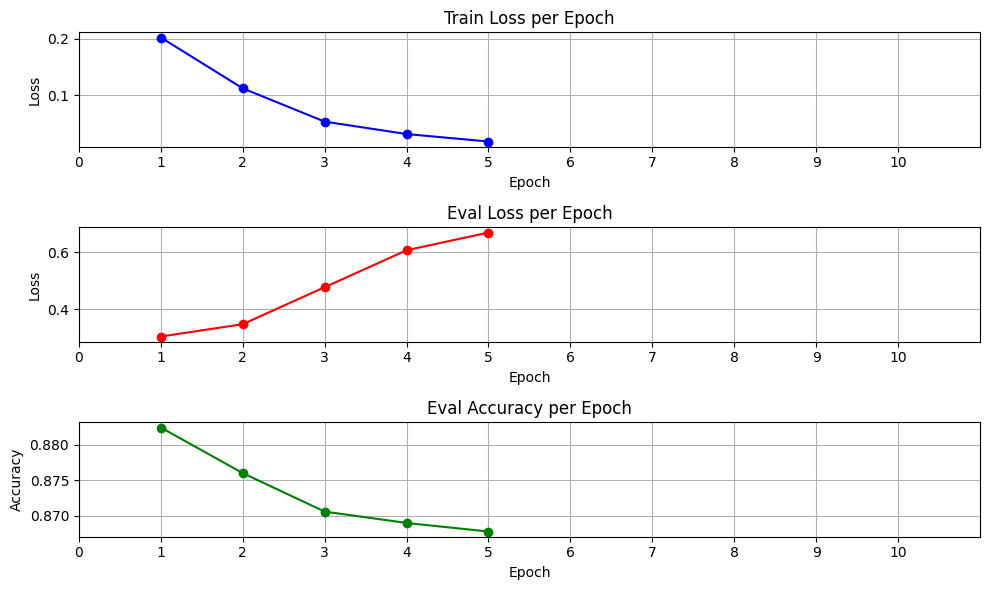

{'loss': 0.0143, 'grad_norm': 25.641735076904297, 'learning_rate': 0.0004, 'epoch': 6.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.7268674373626709, 'eval_accuracy': 0.8664, 'eval_runtime': 3.4417, 'eval_samples_per_second': 1452.776, 'eval_steps_per_second': 11.622, 'epoch': 6.0}


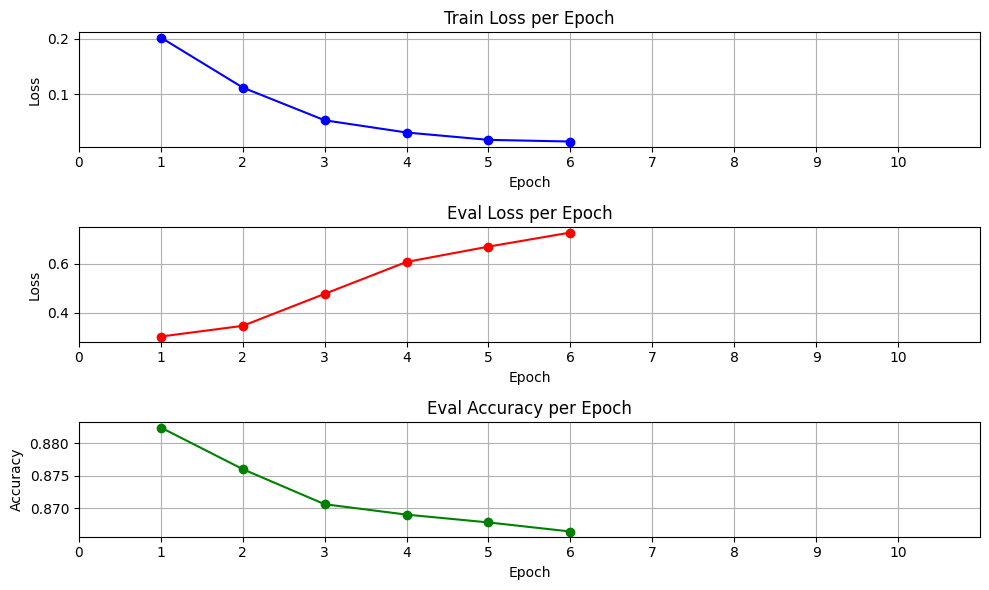

{'loss': 0.0106, 'grad_norm': 0.009760530665516853, 'learning_rate': 0.0003, 'epoch': 7.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.7416312098503113, 'eval_accuracy': 0.8704, 'eval_runtime': 3.7496, 'eval_samples_per_second': 1333.488, 'eval_steps_per_second': 10.668, 'epoch': 7.0}


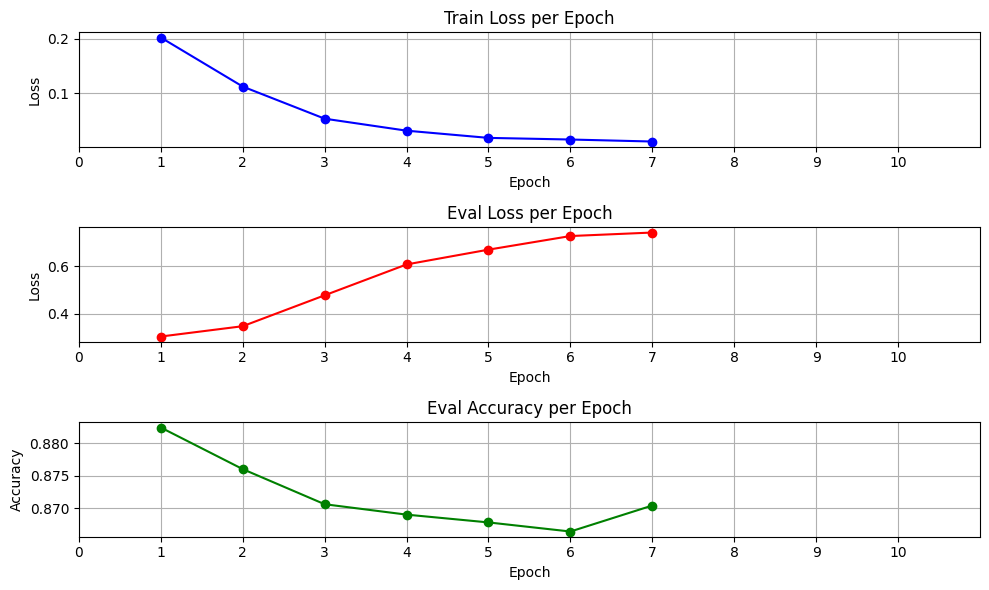

{'loss': 0.0107, 'grad_norm': 0.011470048688352108, 'learning_rate': 0.0002, 'epoch': 8.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.7477385401725769, 'eval_accuracy': 0.8706, 'eval_runtime': 3.8663, 'eval_samples_per_second': 1293.238, 'eval_steps_per_second': 10.346, 'epoch': 8.0}


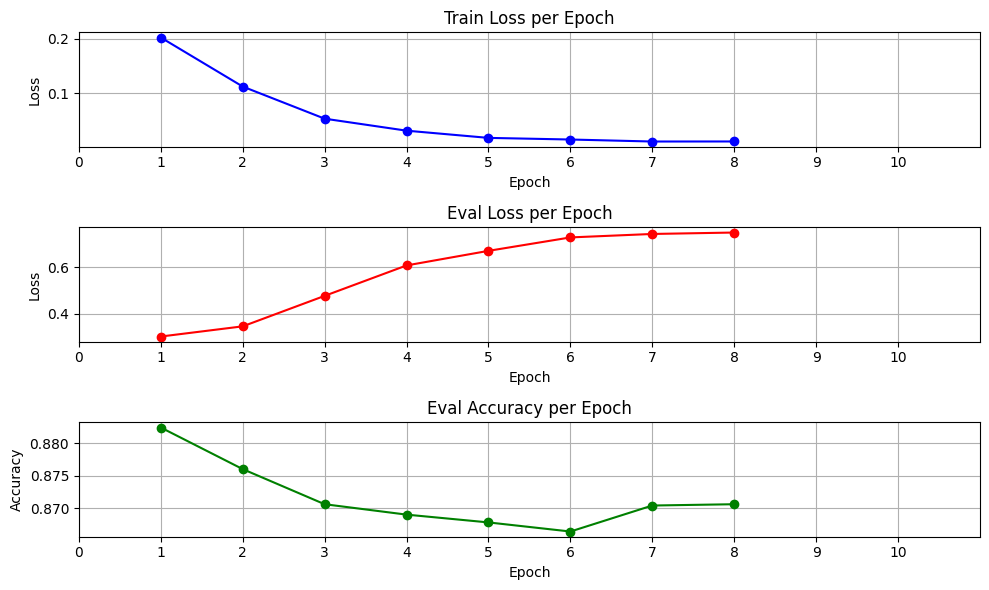

{'loss': 0.0097, 'grad_norm': 0.012107872404158115, 'learning_rate': 0.0001, 'epoch': 9.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.7356857061386108, 'eval_accuracy': 0.8712, 'eval_runtime': 3.9574, 'eval_samples_per_second': 1263.466, 'eval_steps_per_second': 10.108, 'epoch': 9.0}


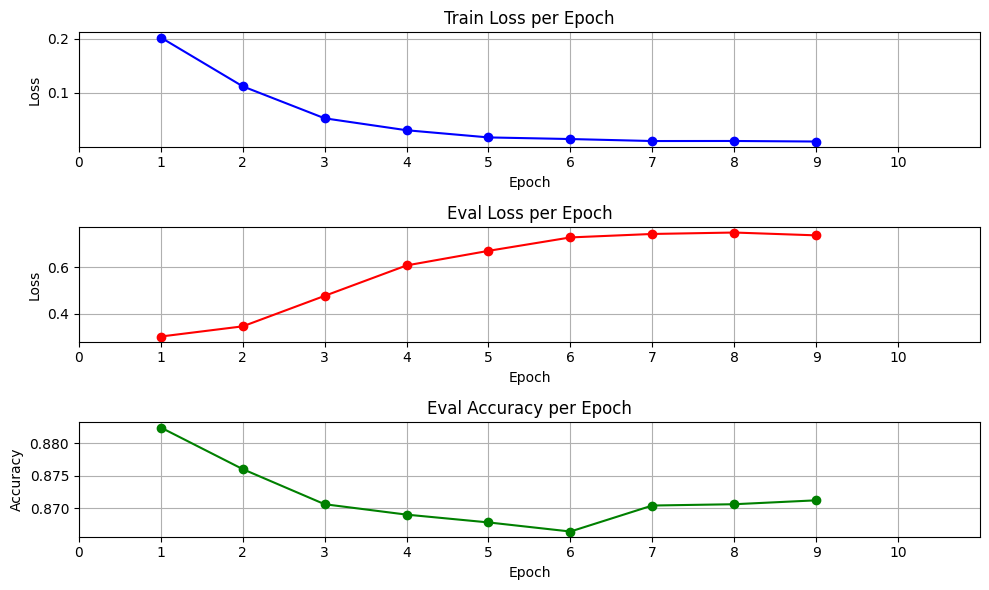

{'loss': 0.0088, 'grad_norm': 0.012672648765146732, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.7343243956565857, 'eval_accuracy': 0.8722, 'eval_runtime': 3.5854, 'eval_samples_per_second': 1394.557, 'eval_steps_per_second': 11.156, 'epoch': 10.0}


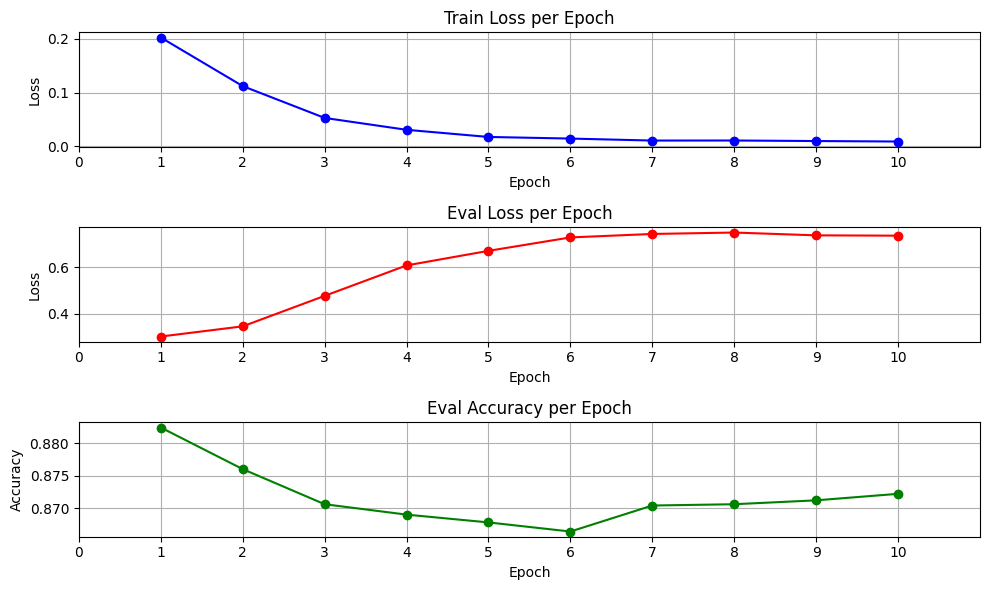

{'train_runtime': 376.7838, 'train_samples_per_second': 530.808, 'train_steps_per_second': 4.167, 'train_loss': 0.04688146038419881, 'epoch': 10.0}
Best model was saved at: hf_transformer/checkpoint-157
Best epoch: 1.0
Best eval_accuracy: 0.8824


TrainOutput(global_step=1570, training_loss=0.04688146038419881, metrics={'train_runtime': 376.7838, 'train_samples_per_second': 530.808, 'train_steps_per_second': 4.167, 'total_flos': 33699840000000.0, 'train_loss': 0.04688146038419881, 'epoch': 10.0})

In [82]:
trainer.train()

보시다시피 training loss는 잘 떨어지는 반면, validation loss는 중간부터 쭉 올라가는 것을 볼 수 있습니다.
Overfitting이 일어났다고 볼 수 있습니다.

위와 같이 학습이 끝난 후 validation loss가 가장 낮은 모델을 가지고 test data의 성능을 평가하는 것은 다음과 같이 구현할 수 있습니다.


In [86]:
trainer.evaluate(imdb_test)

{'eval_loss': 0.34192368388175964,
 'eval_accuracy': 0.8644,
 'eval_runtime': 17.3383,
 'eval_samples_per_second': 1441.893,
 'eval_steps_per_second': 11.304,
 'epoch': 10.0}

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.


In [87]:
trainer.save_model()

그리고 저장한 모델을 가지고 다른 예시들을 예측하는 것은 다음과 같이 구현할 수 있습니다.


In [92]:
from transformers import pipeline


classifier = pipeline("sentiment-analysis", model="./hf_transformer/", device="mps")
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))

[{'label': 'LABEL_0', 'score': 0.9928272366523743}]
[{'label': 'LABEL_1', 'score': 0.9930522441864014}]


HuggingFace의 `pipeline`은 다양한 모델들에 대하여 서비스에 사용할 수 있는 형태들을 제공합니다.
여기서는 영화 리뷰가 주어졌을 때, label이 0(부정적인 리뷰)인지 1(긍정적인 리뷰)인지 예측 결과를 보여줄 뿐만 아니라 그 신뢰도를 `score`로 넘겨주게 됩니다.

이처럼 HuggingFace를 활용하면 모델이나 예측, 학습 코드를 구현할 필요 없이 인자로 설정값들만 넘겨주면 쉽게 구현 할 수 있습니다.


## Transfer learning

이번에는 task는 영화 리뷰 감정 분석으로 유지하되, 모델을 distilbert를 fine-tuning하는 것으로 바꿔보겠습니다.
모델은 다음과 같이 불러올 수 있습니다.


In [93]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`id2label`과 `label2id`는 예측 결과의 가독성을 위해서 추가하였습니다.
기존과 같이 `AutoModelForSequenceClassification`를 사용하고 있습니다.
달라진 점은 `from_config`가 아닌 `from_pretrained`를 사용한다는 것입니다.
`from_pretrained`를 사용하면 HuggingFace hub에 있는 pre-trained 모델들을 사용할 수 있습니다.
감정 분석 문제의 class 수에 맞춰 `num_labels`를 2로 설정하면 모델 구현은 거의 끝났습니다.

이번에는 마지막 layer를 제외한 parameter들을 freeze해보겠습니다.
그 전에 freeze 해야 하는 layer들을 확인하기 위해 `model`을 출력해보겠습니다.


In [94]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

보시다시피 `distilbert`는 기존의 distilbert 모델에 해당하고 나머지 `pre_classifier`, `classifier`는 text 분류를 위해 새롭게 추가된 layer들입니다.
즉, 다음과 같이 `distilbert`에 해당하는 parameter들만 freeze하면 됩니다.


In [95]:
for param in model.distilbert.parameters():
    param.requires_grad = False

이러면 모델 구현은 완전히 마쳤습니다.
다음은 distilbert를 pre-train할 때 사용했던 tokenizer를 불러오고, 이 tokenizer를 가지고 이전과 똑같이 imdb dataset를 전처리합니다.


In [96]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)


imdb_tokenized = imdb.map(preprocess_function, batched=True)
imdb_split = imdb_tokenized["train"].train_test_split(test_size=0.2)
imdb_train, imdb_val = imdb_split["train"], imdb_split["test"]
imdb_test = imdb_tokenized["test"]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

나머지는 기존의 학습과정과 완전히 동일합니다. `training_args`는 기존과 똑같이 활용할 때 distilbert를 fine-tuning하는 코드는 다음과 같습니다.


  0%|          | 0/314 [00:00<?, ?it/s]

{'loss': 0.3296, 'grad_norm': 0.6072217226028442, 'learning_rate': 0.001, 'epoch': 1.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.3733789622783661, 'eval_accuracy': 0.834, 'eval_runtime': 62.7309, 'eval_samples_per_second': 79.706, 'eval_steps_per_second': 0.638, 'epoch': 1.0}


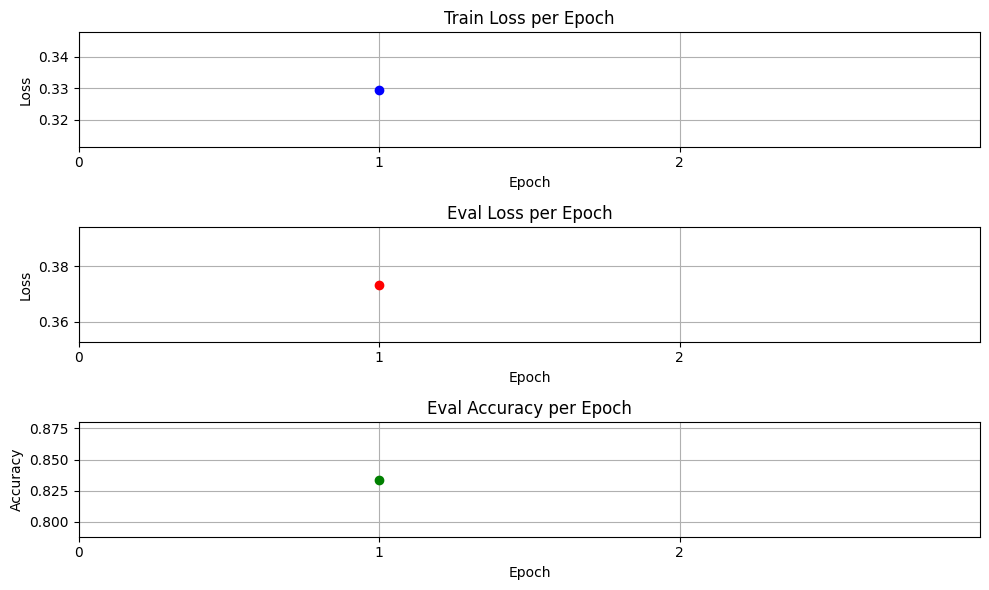

{'loss': 0.3351, 'grad_norm': 0.79581618309021, 'learning_rate': 0.001, 'epoch': 2.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.3216966688632965, 'eval_accuracy': 0.8664, 'eval_runtime': 62.0361, 'eval_samples_per_second': 80.598, 'eval_steps_per_second': 0.645, 'epoch': 2.0}


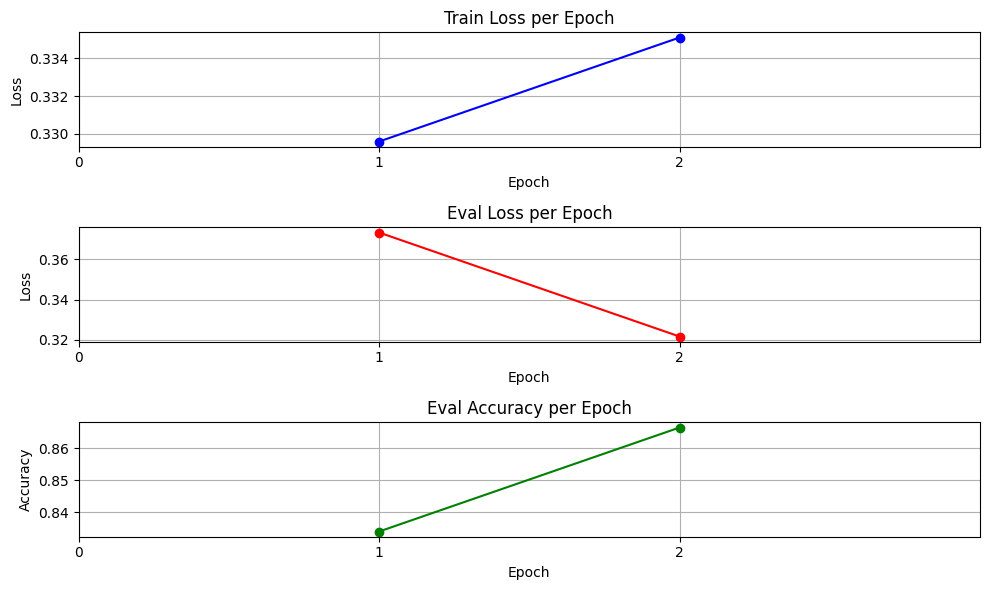

{'train_runtime': 733.6551, 'train_samples_per_second': 54.522, 'train_steps_per_second': 0.428, 'train_loss': 0.3323460232680011, 'epoch': 2.0}
Best model was saved at: hf_transformer_01/checkpoint-314
Best epoch: 2.0
Best eval_accuracy: 0.8664


TrainOutput(global_step=314, training_loss=0.3323460232680011, metrics={'train_runtime': 733.6551, 'train_samples_per_second': 54.522, 'train_steps_per_second': 0.428, 'total_flos': 5298695946240000.0, 'train_loss': 0.3323460232680011, 'epoch': 2.0})

In [111]:
training_args = TrainingArguments(
    output_dir="hf_transformer_01",  # 모델, log 등을 저장할 directory
    num_train_epochs=2,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="eval_accuracy",  # best model을 accuracy 기준으로 선정
    greater_is_better=True,
    lr_scheduler_type="constant",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        PlotCallback(),
        BestModelCallback(),
    ],
)


trainer.train()
# trainer.save_model()

  0%|          | 0/628 [00:00<?, ?it/s]

{'loss': 0.3334, 'grad_norm': 0.753578245639801, 'learning_rate': 0.001, 'epoch': 3.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.35952579975128174, 'eval_accuracy': 0.8354, 'eval_runtime': 66.4529, 'eval_samples_per_second': 75.241, 'eval_steps_per_second': 0.602, 'epoch': 3.0}


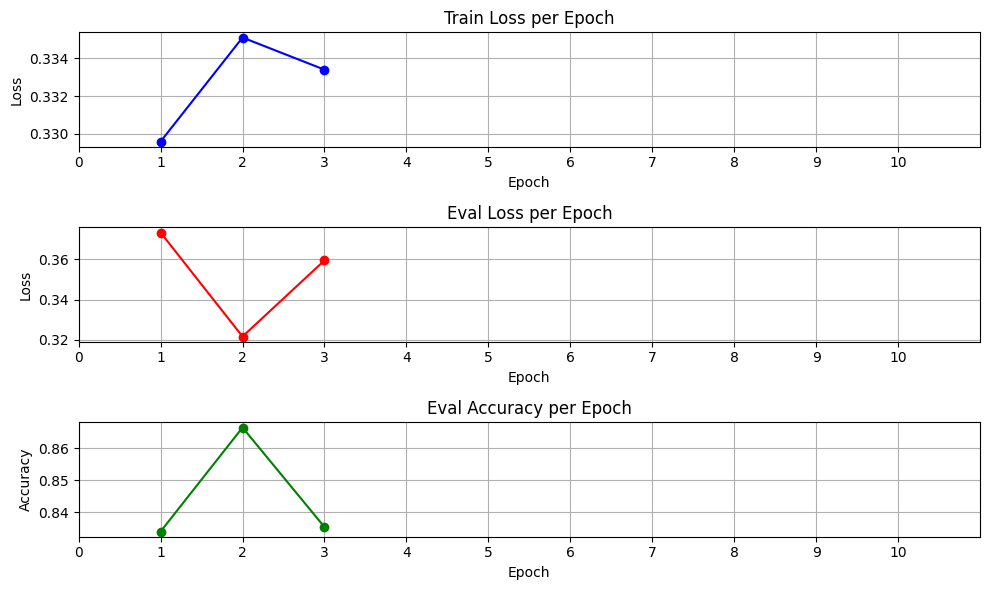

{'loss': 0.3432, 'grad_norm': 1.486527681350708, 'learning_rate': 0.001, 'epoch': 4.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.33921605348587036, 'eval_accuracy': 0.8582, 'eval_runtime': 62.2937, 'eval_samples_per_second': 80.265, 'eval_steps_per_second': 0.642, 'epoch': 4.0}


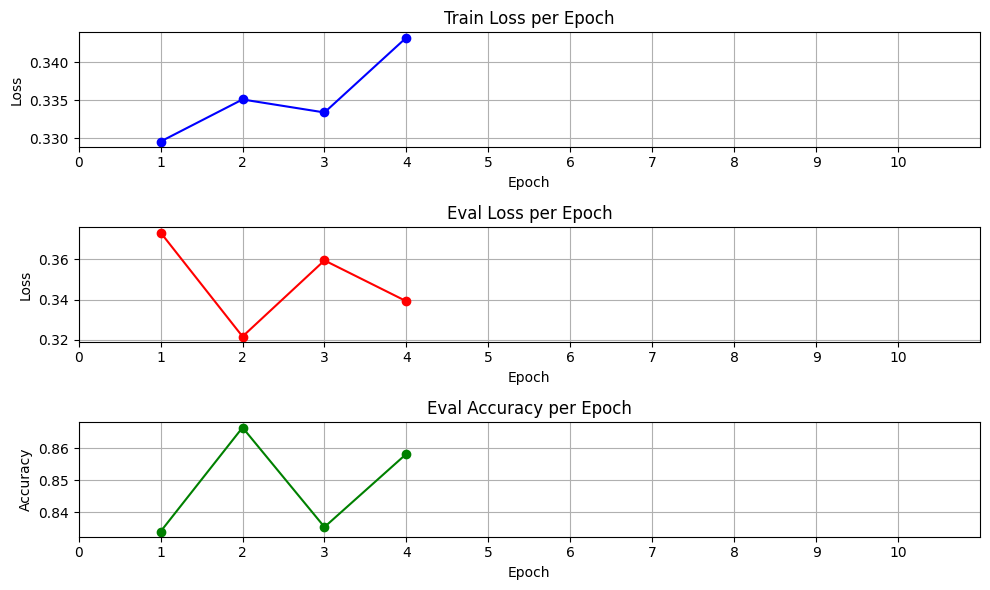

{'train_runtime': 796.5616, 'train_samples_per_second': 100.914, 'train_steps_per_second': 0.788, 'train_loss': 0.16914275345528962, 'epoch': 4.0}
Best model was saved at: hf_transformer_01/checkpoint-314
Best epoch: 2.0
Best eval_accuracy: 0.8664


In [113]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 628
    training_args.learning_rate = 8e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-314")
    # 이 블록 내에서만 경고가 무시됨

  0%|          | 0/942 [00:00<?, ?it/s]

{'loss': 0.3318, 'grad_norm': 0.6025442481040955, 'learning_rate': 0.001, 'epoch': 5.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.3085740804672241, 'eval_accuracy': 0.8738, 'eval_runtime': 64.7592, 'eval_samples_per_second': 77.209, 'eval_steps_per_second': 0.618, 'epoch': 5.0}


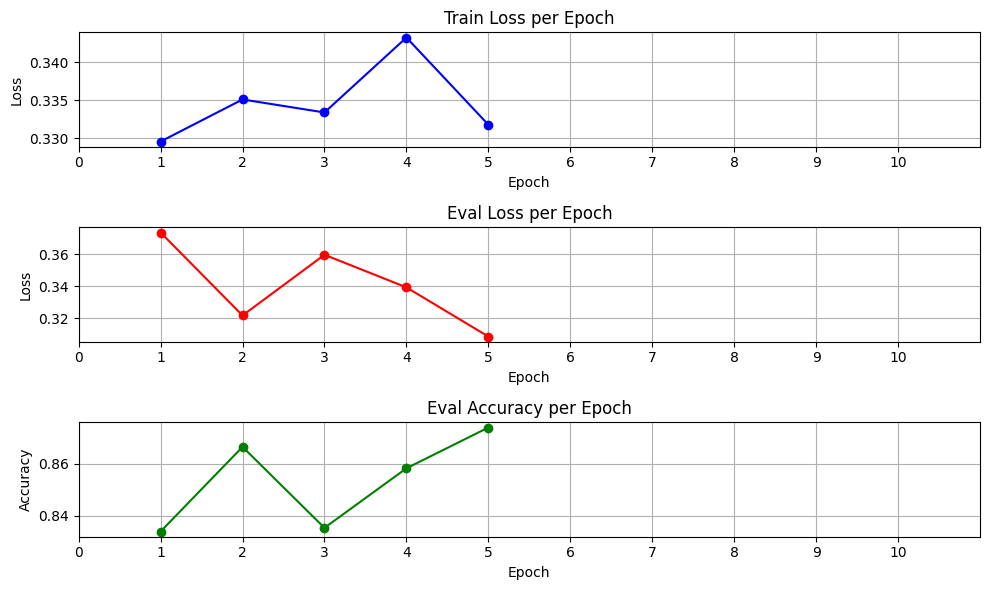

{'loss': 0.326, 'grad_norm': 0.7650651931762695, 'learning_rate': 0.001, 'epoch': 6.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.30668404698371887, 'eval_accuracy': 0.8702, 'eval_runtime': 61.9399, 'eval_samples_per_second': 80.723, 'eval_steps_per_second': 0.646, 'epoch': 6.0}


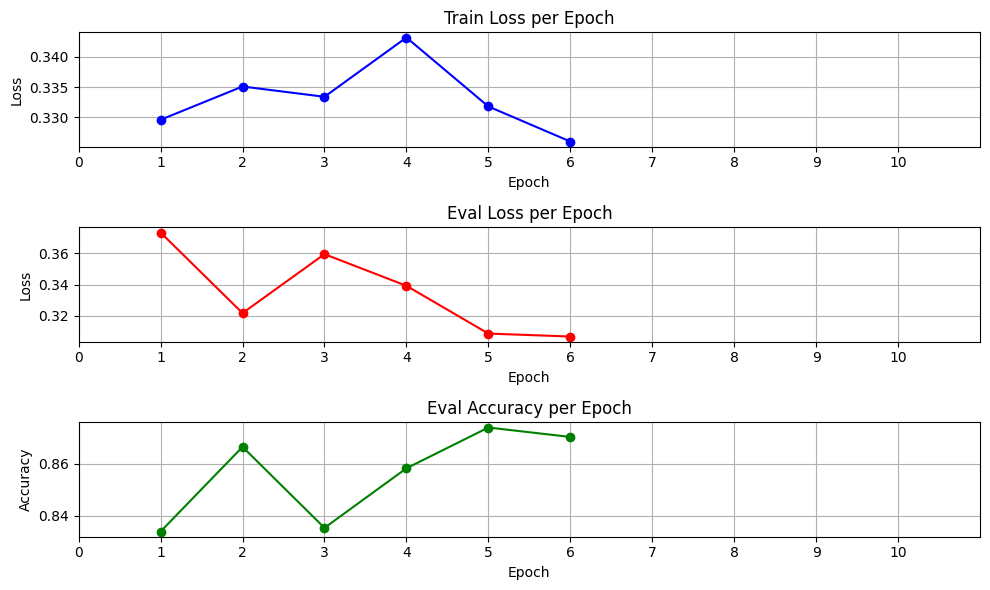

{'train_runtime': 729.5647, 'train_samples_per_second': 165.271, 'train_steps_per_second': 1.291, 'train_loss': 0.10963352065683676, 'epoch': 6.0}
Best model was saved at: hf_transformer_01/checkpoint-785
Best epoch: 5.0
Best eval_accuracy: 0.8738


In [115]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 942
    training_args.learning_rate = 6e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-628")
    # 이 블록 내에서만 경고가 무시됨

  0%|          | 0/1256 [00:00<?, ?it/s]

{'loss': 0.3225, 'grad_norm': 0.8869338035583496, 'learning_rate': 0.001, 'epoch': 7.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.30655670166015625, 'eval_accuracy': 0.8748, 'eval_runtime': 64.1189, 'eval_samples_per_second': 77.98, 'eval_steps_per_second': 0.624, 'epoch': 7.0}


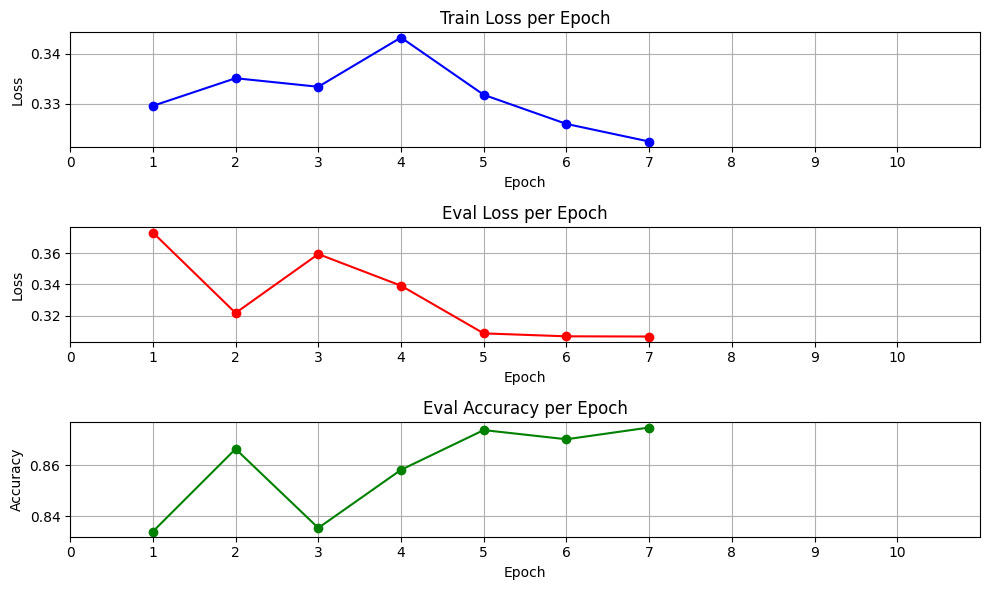

{'loss': 0.3232, 'grad_norm': 1.6841331720352173, 'learning_rate': 0.001, 'epoch': 8.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.3031559884548187, 'eval_accuracy': 0.8718, 'eval_runtime': 62.4889, 'eval_samples_per_second': 80.014, 'eval_steps_per_second': 0.64, 'epoch': 8.0}


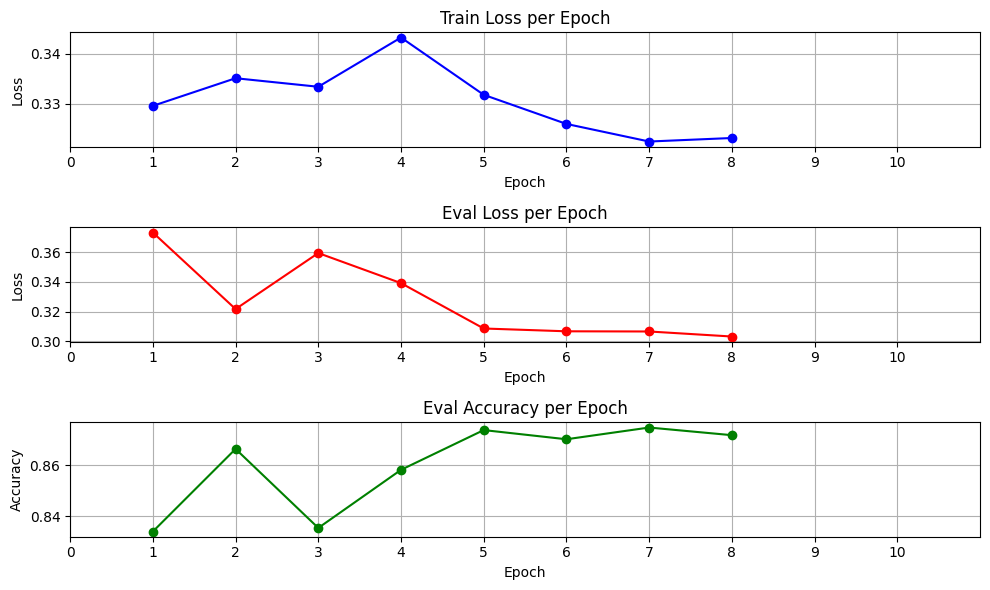

{'train_runtime': 731.864, 'train_samples_per_second': 219.669, 'train_steps_per_second': 1.716, 'train_loss': 0.08070282419775701, 'epoch': 8.0}
Best model was saved at: hf_transformer_01/checkpoint-1099
Best epoch: 7.0
Best eval_accuracy: 0.8748


In [116]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 1256
    training_args.learning_rate = 4e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-942")
    # 이 블록 내에서만 경고가 무시됨

  0%|          | 0/1570 [00:00<?, ?it/s]

{'loss': 0.3204, 'grad_norm': 0.7041274309158325, 'learning_rate': 0.001, 'epoch': 9.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.3056144416332245, 'eval_accuracy': 0.8732, 'eval_runtime': 63.6958, 'eval_samples_per_second': 78.498, 'eval_steps_per_second': 0.628, 'epoch': 9.0}


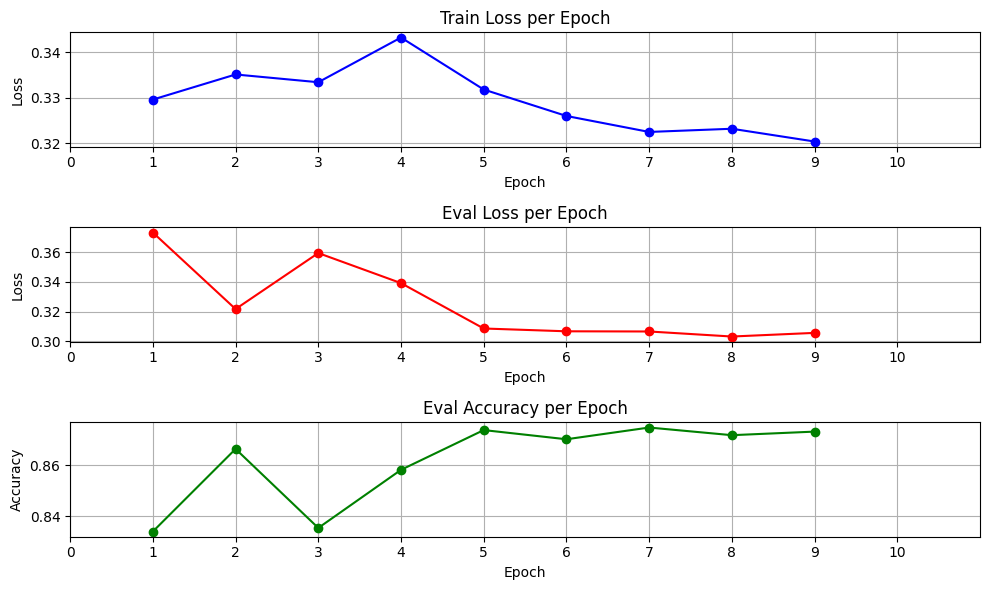

{'loss': 0.3185, 'grad_norm': 1.3600988388061523, 'learning_rate': 0.001, 'epoch': 10.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.3042050302028656, 'eval_accuracy': 0.8708, 'eval_runtime': 64.0613, 'eval_samples_per_second': 78.05, 'eval_steps_per_second': 0.624, 'epoch': 10.0}


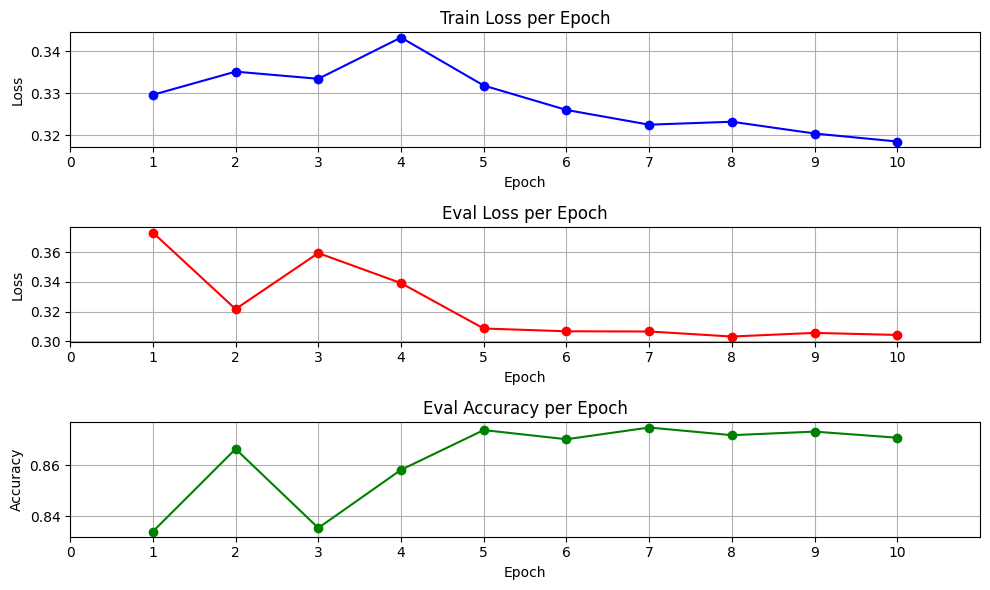

{'train_runtime': 735.8292, 'train_samples_per_second': 273.107, 'train_steps_per_second': 2.134, 'train_loss': 0.06389514412849572, 'epoch': 10.0}
Best model was saved at: hf_transformer_01/checkpoint-1099
Best epoch: 7.0
Best eval_accuracy: 0.8748


In [117]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 1570
    training_args.learning_rate = 2e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-1256")
    # 이 블록 내에서만 경고가 무시됨

In [119]:
trainer.save_model()

학습한 모델에 대한 결과는 다음과 같습니다.


In [118]:
trainer.predict(imdb_test)

  0%|          | 0/196 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 1.5661144 , -1.5619496 ],
       [-0.01046071,  0.01920732],
       [ 2.106728  , -2.038813  ],
       ...,
       [ 0.33184248, -0.29701173],
       [ 0.9192971 , -0.83429575],
       [-1.2356445 ,  1.2605515 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.30594876408576965, 'test_accuracy': 0.86892, 'test_runtime': 316.0194, 'test_samples_per_second': 79.109, 'test_steps_per_second': 0.62})

In [121]:
classifier = pipeline("sentiment-analysis", model="./hf_transformer_01/", device="mps")
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))

[{'label': 'NEGATIVE', 'score': 0.989370584487915}]
[{'label': 'POSITIVE', 'score': 0.999358594417572}]
